## Inference

In [1]:
from ultralytics import YOLO
import cv2
import os
import matplotlib.pyplot as plt
from infer_helpers import *

# Load a model
model = YOLO("test_yolo/experiment_14/weights/best.pt")

### Perdict directory
Create a directory as a source.

`stream=True` 
Enables memory-efficient processing for long videos or numerous images by returning a generator of Results objects instead of loading all frames into memory at once.



In [2]:
src_dir = "path/to/dir"
results = model(src_dir, stream=True)  # generator of Results objects

### Predict single image

In [3]:
img = 'datasets/DOTAv1.5/images/test/P0055.jpg'
results = model(img, 
                show_boxes=True, # Draws boxes 
                save_txt=True, # Saves coords in object
                save=True,) # Saved in output_dir


image 1/1 /home/jupyter-dai7591/yolo/datasets/DOTAv1.5/images/test/P0055.jpg: 640x640 3.5ms
Speed: 5.2ms preprocess, 3.5ms inference, 163.8ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/obb/predict8
1 label saved to runs/obb/predict8/labels


### Visualize

Annotated image loaded from: runs/obb/predict8/P0055.jpg


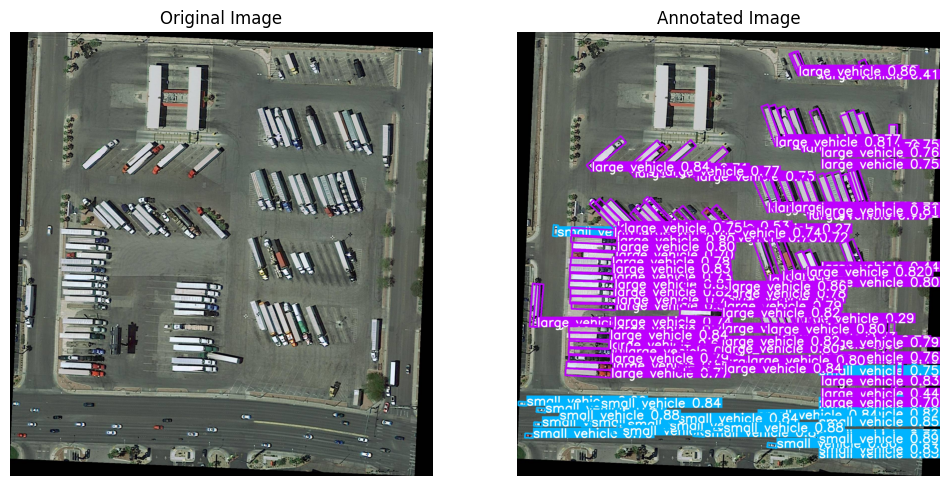

In [4]:
# List image files in the save_dir
saved_folder = results[0].save_dir
img_files = [os.path.join(saved_folder, f) for f in os.listdir(saved_folder) if f.endswith(('.jpg', '.jpeg', '.png'))]

if not img_files:
    raise FileNotFoundError("No image files found in the saved directory!")

annotated_img_path = img_files[0]  # choose the first image file
print("Annotated image loaded from:", annotated_img_path)

# Read images using OpenCV
img1 = cv2.imread(img)
img2 = cv2.imread(annotated_img_path)

# Convert BGR to RGB for display
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

# Create a figure with 2 subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(img1)
axs[0].axis('off')
axs[0].set_title("Original Image")

axs[1].imshow(img2)
axs[1].axis('off')
axs[1].set_title("Annotated Image")
plt.show()

## SAM2
1) Load bounding boxes from output txt file
2) Parse them (am I using that word correctly?)
3) Use them as prompts

### Load model 

In [5]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

# build the core SAM2 model
from sam2.build_sam import build_sam2  

# promptable static-image segmentation
from sam2.sam2_image_predictor import SAM2ImagePredictor

In [6]:
model_cfg   = "configs/sam2.1/sam2.1_hiera_t.yaml"
checkpoint  = "checkpoints/sam2.1_hiera_tiny.pt"

sam_model   = build_sam2(model_cfg, checkpoint, device="cuda")
predictor   = SAM2ImagePredictor(sam_model)

### Create embedding of the image

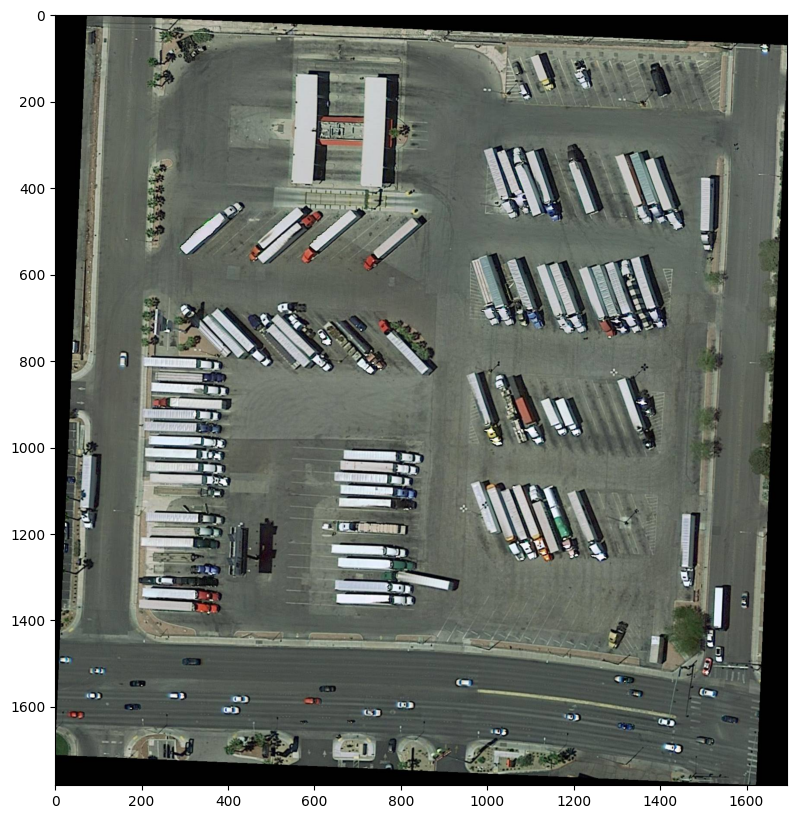

In [7]:
image = Image.open('datasets/DOTAv1.5/images/test/P0055.jpg')
image = np.array(image.convert("RGB"))
predictor.set_image(image)

plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('on')
plt.show()

### Process yolo bounding box
Load a YOLO-OBB .txt file and convert to axis-aligned boxes in xyxy format.

Supports two OBB formats:
    - Polygon (9 values per line): class, x1, y1, x2, y2, x3, y3, x4, y4
    - Rotated rect (6 values per line): class, x_center, y_center, width, height, angle

Returns an (N,4) array:
[[x_min, y_min, x_max, y_max], ...]

In [8]:
my_boxes = load_yolo_obb_as_xyxy('runs/obb/predict4/labels/P0055.txt', 'datasets/DOTAv1.5/images/test/P0055.jpg')

### Creating mask based on a box

In [9]:
input_boxes = my_boxes

print(input_boxes.shape)
print(input_boxes)

masks, scores, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_boxes,
    multimask_output=False,
)

print(masks.shape)

(126, 4)
[[     1388.4      1624.6      1434.2      1650.8]
 [     783.56      1585.1      828.12      1606.8]
 [     170.05      1538.6       207.2      1556.1]
 [       1003      1648.7      1041.7      1669.6]
 [     665.49      1001.8      849.69      1040.4]
 [     1090.5      82.214      1152.6      179.67]
 [     1485.4        1557      1529.4      1582.3]
 [     1325.8        1562      1358.5      1580.8]
 [     611.34      1551.4      646.12      1569.9]
 [     642.66      1337.5      829.84      1369.4]
 [     923.99        1536      965.01      1555.9]
 [      573.8      1577.8      611.93      1597.7]
 [     278.17       420.9      437.24         563]
 [     705.86      1602.8      751.36      1625.1]
 [     209.56      1208.5      373.05      1235.8]
 [      290.3      1488.3      336.86      1508.1]
 [     211.42      938.94      383.26      970.24]
 [     1518.4      1322.3      1545.2      1419.3]
 [     208.48      1000.2      391.17      1032.7]
 [     1479.6      166

(126, 1, 1782, 1695)


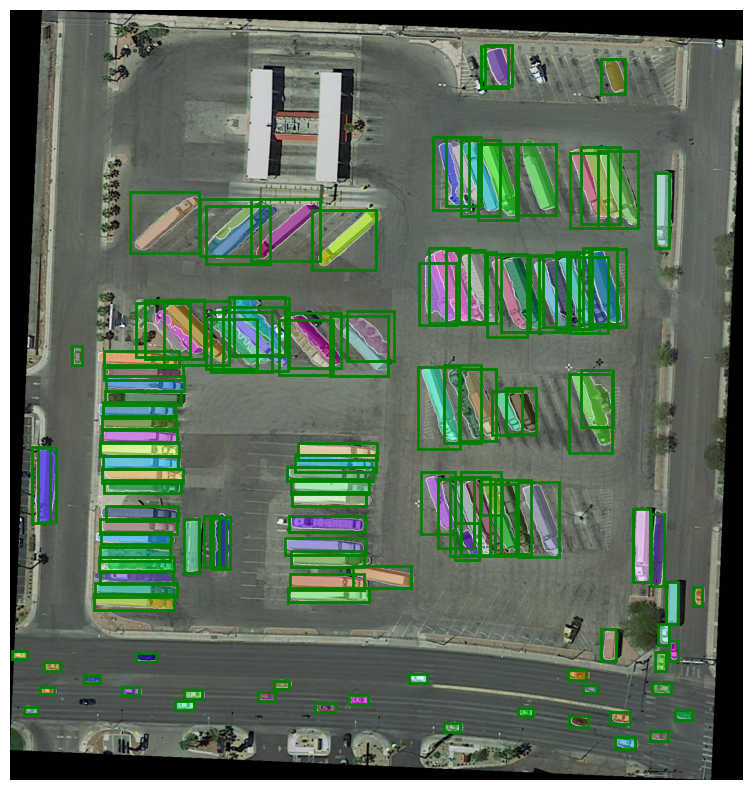

In [11]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
for mask in masks:
    show_mask(mask.squeeze(0), plt.gca(), random_color=True)
for box in input_boxes:
    show_box(box, plt.gca())
plt.axis('off')
plt.show()

**Inference arguments**


| Argument    | Type                  | Default          | Description                                                                                                                                                                 |
|-------------|-----------------------|------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| show        | bool                  | False            | If True, displays the annotated images or videos in a window. Useful for immediate visual feedback during development or testing.                                         |
| save        | bool                  | False or True    | Enables saving of the annotated images or videos to file. Useful for documentation, further analysis, or sharing results. Defaults to True when using CLI & False when used in Python. |
| save_frames | bool                  | False            | When processing videos, saves individual frames as images. Useful for extracting specific frames or for detailed frame-by-frame analysis.                                  |
| save_txt    | bool                  | False            | Saves detection results in a text file, following the format `[class] [x_center] [y_center] [width] [height] [confidence]`. Useful for integration with other analysis tools. |
| save_conf   | bool                  | False            | Includes confidence scores in the saved text files. Enhances the detail available for post-processing and analysis.                                                          |
| save_crop   | bool                  | False            | Saves cropped images of detections. Useful for dataset augmentation, analysis, or creating focused datasets for specific objects.                                            |
| show_labels | bool                  | True             | Displays labels for each detection in the visual output. Provides immediate understanding of detected objects.                                                              |
| show_conf   | bool                  | True             | Displays the confidence score for each detection alongside the label. Gives insight into the model's certainty for each detection.                                            |
| show_boxes  | bool                  | True             | Draws bounding boxes around detected objects. Essential for visual identification and location of objects in images or video frames.                                         |
| line_width  | None or int           | None             | Specifies the line width of bounding boxes. If None, the line width is automatically adjusted based on the image size. Provides visual customization for clarity.         |
| font_size   | float                 | None             | Text font size for annotations. Scales automatically with image size if set to None.                                                                                        |
| font        | str                   | 'Arial.ttf'      | Font name or path for text annotations in the visualization.                                                                                                               |
| pil         | bool                  | False            | Return image as a PIL Image object instead of numpy array.                                                                                                                 |
| kpt_radius  | int                   | 5                | Radius of keypoints when visualizing pose estimation results.                                                                                                              |
| kpt_line    | bool                  | True             | Connect keypoints with lines when visualizing pose estimation.                                                                                                             |
| masks       | bool                  | True             | Display segmentation masks in the visualization output.                                                                                                                  |
| probs       | bool                  | True             | Include classification probabilities in the visualization.                                                                                                               |
| filename    | str                   | None             | Path and filename to save the annotated image when save=True.                                                                                                              |
| color_mode  | str                   | 'class'          | Specify the coloring mode for visualizations, e.g., 'instance' or 'class'.                                                                                                  |
| txt_color   | tuple[int, int, int]   | (255, 255, 255)  | RGB text color for classification task annotations.                                                                                                                      |